### Libraries, random seed, wandb installation

In [1]:
%%capture
!pip install uv
!uv pip install --no-deps unsloth vllm==0.8.5.post1
import sys, re, requests; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
!uv pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!uv pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer

f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
with open("vllm_requirements.txt", "wb") as file:
    file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
!uv pip install -r vllm_requirements.txt
!uv pip install pympler

In [2]:
import json
import os
import random
import wandb
from collections import defaultdict
import re
from scipy.stats import pearsonr
from pympler import asizeof
import matplotlib.pyplot as plt
import time
import numpy as np
import torch

### Unsloth

Load up `Qwen 2.5 0.5B Instruct`, and set parameters

In [3]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.8, # Reduce if out of memory
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-22 10:34:54 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 07-22 10:34:55 [__init__.py:239] Automatically detected platform cuda.
Unsloth: Patching vLLM v1 graph capture
Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.7.6: Fast Qwen2 patching. Transformers: 4.53.2. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit with actual GPU utilization = 79.24%
Unsloth: Your GPU has CUDA compute 

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

INFO 07-22 10:35:42 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 07-22 10:35:42 [cuda.py:289] Using XFormers backend.
INFO 07-22 10:35:42 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 07-22 10:35:42 [model_runner.py:1108] Starting to load model unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit...
INFO 07-22 10:35:43 [loader.py:1187] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 07-22 10:35:44 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

INFO 07-22 10:35:55 [weight_utils.py:281] Time spent downloading weights for unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit: 10.410249 seconds
INFO 07-22 10:35:55 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 07-22 10:35:56 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 07-22 10:35:56 [model_runner.py:1140] Model loading took 0.5747 GiB and 13.319177 seconds
INFO 07-22 10:36:04 [worker.py:287] Memory profiling takes 7.17 seconds
INFO 07-22 10:36:04 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.79) = 11.68GiB
INFO 07-22 10:36:04 [worker.py:287] model weights take 0.57GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 1.23GiB; the rest of the memory reserved for KV Cache is 9.85GiB.
INFO 07-22 10:36:04 [executor_base.py:112] # cuda blocks: 53816, # CPU blocks: 0
INFO 07-22 10:36:04 [executor_base.py:117] Maximum concurrency for 1024 tokens per request: 840.88x
INFO 07-22 10:36:04 [vllm_utils.py:669] Unsloth: Running patched vLLM v0 `capture_model`.
INFO 07-22 10:36:04 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run 

Capturing CUDA graph shapes:   0%|          | 0/31 [00:00<?, ?it/s]

INFO 07-22 10:36:35 [model_runner.py:1592] Graph capturing finished in 30 secs, took 0.43 GiB
INFO 07-22 10:36:35 [vllm_utils.py:676] Unsloth: Patched vLLM v0 graph capture finished in 30 secs.
INFO 07-22 10:36:36 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 39.36 seconds
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm', 'k_norm', 'q_norm']
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm', 'k_norm', 'q_norm']


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

### Data analysis

In [4]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files={
    'train': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl',
    # 'test': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl'
})['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset_socratic = load_dataset('json', data_files={
    'train': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train_socratic.jsonl',
    # 'test': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl'
})['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
def get_logic_steps(sample):
    return len(sample["answer"].split(" ** ")) - 1

dataset_socratic = dataset_socratic.map(lambda sample: {"logic_steps": get_logic_steps(sample)})
train_dataset = train_dataset.add_column("logic_steps", dataset_socratic["logic_steps"])

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [7]:
train_dataset = train_dataset.sort("logic_steps")
print(train_dataset[0]["logic_steps"])
print(train_dataset[3000]["logic_steps"])
print(train_dataset[5000]["logic_steps"])

2
3
4


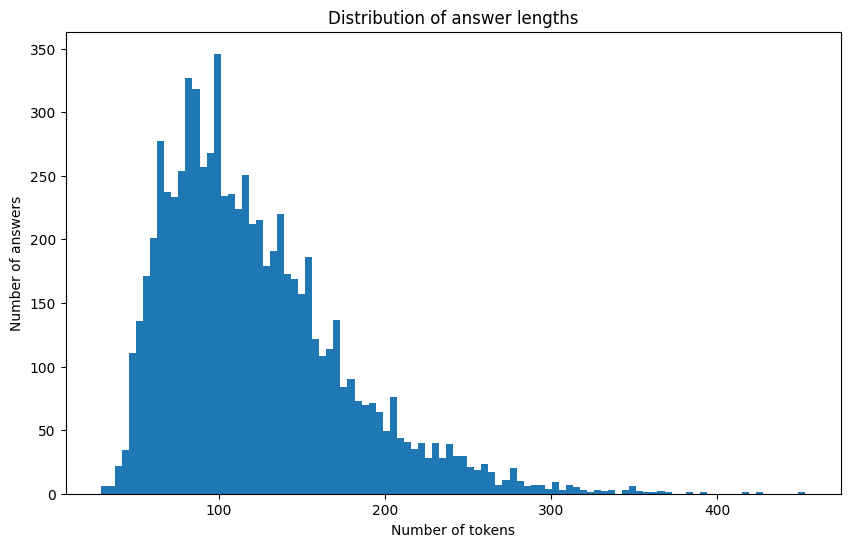

Average length: 121.7933
Minimum length: 29
Maximum length: 453


In [8]:
answers_len = []
answers_logic_steps = []
logic_steps_to_answer_len = defaultdict(list)

for i in range(len(train_dataset)):
    logic_steps = train_dataset[i]["logic_steps"]
    answer_len = len(tokenizer.encode(train_dataset[i]["answer"]))
    answers_logic_steps.append(logic_steps)
    answers_len.append(answer_len)
    logic_steps_to_answer_len[logic_steps].append(answer_len)

plt.figure(figsize=(10, 6))
plt.hist(answers_len, bins=100)
plt.title('Distribution of answer lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Number of answers')
plt.show()

print(f"Average length: {sum(answers_len) / len(answers_len):.4f}")
print(f"Minimum length: {min(answers_len)}")
print(f"Maximum length: {max(answers_len)}")



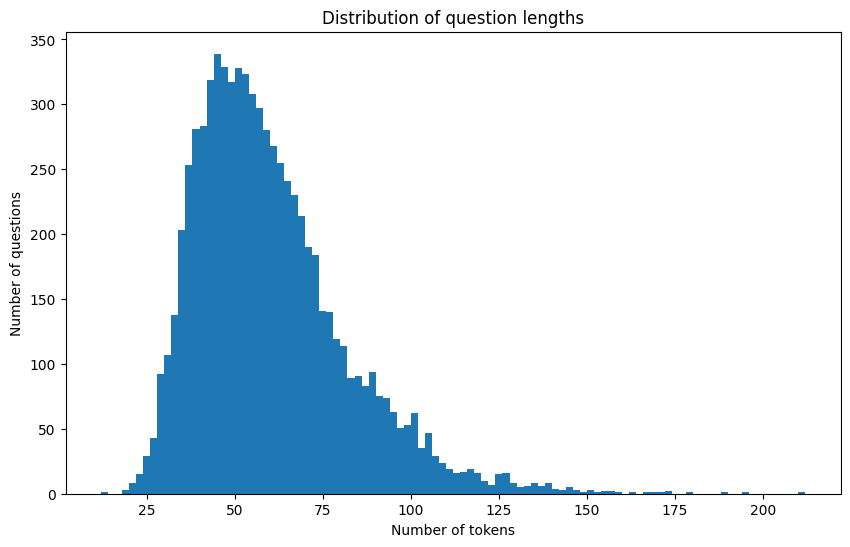

Average length: 59.6473
Minimum length: 12
Maximum length: 212


In [9]:
questions_len = []

for i in range(len(train_dataset)):
    questions_len.append(len(tokenizer.encode(train_dataset[i]["question"])))

plt.figure(figsize=(10, 6))
plt.hist(questions_len, bins=100)
plt.title('Distribution of question lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Number of questions')
plt.show()

print(f"Average length: {sum(questions_len) / len(questions_len):.4f}")
print(f"Minimum length: {min(questions_len)}")
print(f"Maximum length: {max(questions_len)}")

In [10]:
correlation, p_value = pearsonr(questions_len, answers_len)
print(f"Correlation coefficient between question and answer lens: {correlation:.4f} with p-value: {p_value:.4f}")

Correlation coefficient between question and answer lens: 0.5258 with p-value: 0.0000


In [11]:
correlation, p_value = pearsonr(answers_logic_steps, answers_len)
print(f"Corr coeff between required logic steps and answer lens: {correlation:.4f} with p-value: {p_value:.4f}")

Corr coeff between required logic steps and answer lens: 0.7711 with p-value: 0.0000


In [12]:
for key, value in sorted(logic_steps_to_answer_len.items()):
    print(f"If required {key} logic steps ({len(value)} questions):")
    print("Mean answer len:", sum(value) / len(value))
    print(f"Min answer len: {min(value)}")
    print(f"Max answer len: {max(value)}")
    print()

If required 2 logic steps (1960 questions):
Mean answer len: 72.71020408163265
Min answer len: 29
Max answer len: 172

If required 3 logic steps (2149 questions):
Mean answer len: 105.65472312703584
Min answer len: 36
Max answer len: 221

If required 4 logic steps (1660 questions):
Mean answer len: 136.055421686747
Min answer len: 35
Max answer len: 273

If required 5 logic steps (954 questions):
Mean answer len: 169.22222222222223
Min answer len: 51
Max answer len: 359

If required 6 logic steps (419 questions):
Mean answer len: 196.51551312649164
Min answer len: 55
Max answer len: 369

If required 7 logic steps (228 questions):
Mean answer len: 207.51754385964912
Min answer len: 64
Max answer len: 425

If required 8 logic steps (90 questions):
Mean answer len: 228.1
Min answer len: 89
Max answer len: 453

If required 9 logic steps (13 questions):
Mean answer len: 240.30769230769232
Min answer len: 92
Max answer len: 367

